In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import bctools as bc
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv("cs_bisnode_panel.csv")

In [3]:
data = data[(data["year"]>2009) & (data["year"]<2016)]

In [4]:
data["liq_ratio"] = data["curr_assets"]/data["curr_liab"]
median_liqrat = data['liq_ratio'].median()
data['liq_ratio'] = data['liq_ratio'].fillna(median_liqrat)
data['liq_ratio_flag'] = np.where(data['liq_ratio'] == median_liqrat, 1, 0)

In [5]:
data["turn_over_ratio"] = (data["net_dom_sales"]+ data["net_exp_sales"])/(data["curr_assets"] + data["fixed_assets"] + data["intang_assets"] + data["liq_assets"] + data["tang_assets"])

In [6]:
data["roa"] = data["inc_bef_tax"]/(data["curr_assets"] + data["fixed_assets"] + data["intang_assets"] + data["liq_assets"] + data["tang_assets"])
median_roa = data['roa'].median()
data['roa'] = data['roa'].fillna(median_roa)
data['roa_flag'] = np.where(data['roa'] == median_roa, 1, 0)

In [7]:
missings = data.isna().sum(axis=0).sort_values(ascending=False)
cols_to_drop = missings[missings > len(data)*0.3].index.tolist()
data.drop(columns=cols_to_drop, inplace=True)

In [8]:
(data.isna().sum(axis=0)*100/(data.shape[0])).sort_values(ascending=False)

birth_year              25.787263
founded_year            10.983497
gender                  10.979917
ceo_count               10.979917
foreign                 10.979917
female                  10.979917
origin                  10.979917
inoffice_days           10.979917
ind                      2.962901
material_exp             2.456356
personnel_exp            2.456356
amort                    2.456356
extra_profit_loss        2.240373
extra_inc                2.237987
extra_exp                2.237987
sales                    2.232617
inc_bef_tax              2.232617
region_m                 0.273857
profit_loss_year         0.039975
nace_main                0.035202
ind2                     0.035202
share_eq                 0.034008
tang_assets              0.034008
subscribed_cap           0.034008
liq_assets               0.034008
inventories              0.034008
intang_assets            0.034008
fixed_assets             0.034008
curr_liab                0.034008
curr_assets   

C:\Users\Emil\AppData\Local\Temp\ipykernel_16964\3237421645.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(data[data["year"]==2010].corr(), vmin=-1, vmax=1, cmap="YlOrBr")


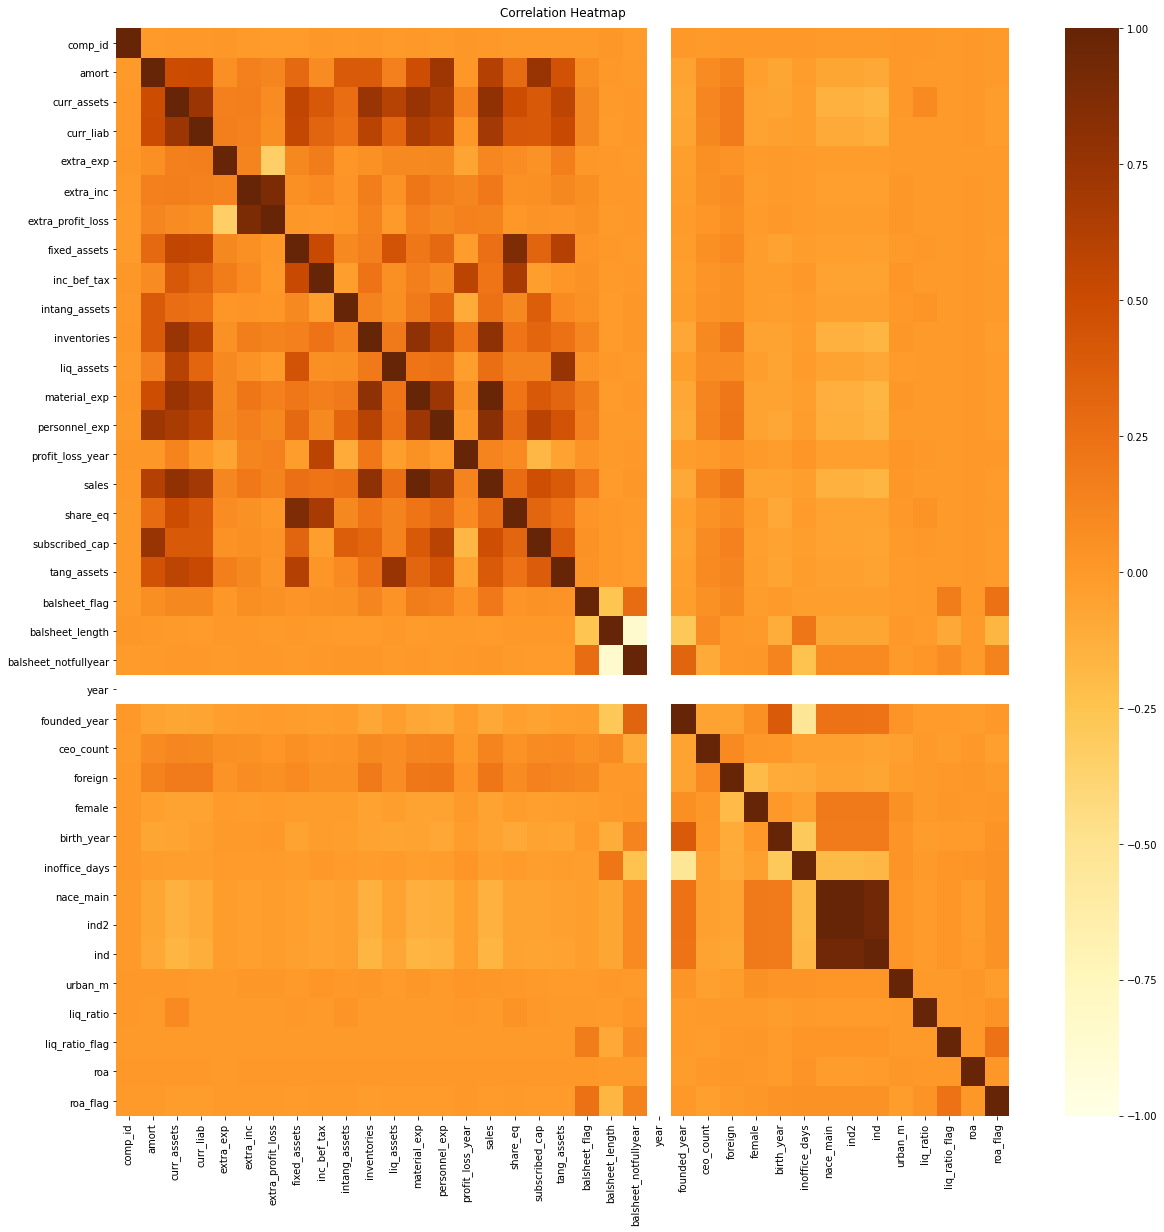

In [9]:
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(data[data["year"]==2010].corr(), vmin=-1, vmax=1, cmap="YlOrBr")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [10]:
median_female = data['female'].median()
median_by =data['birth_year'].median()
median_se =data['share_eq'].median()

data['female'] = data['female'].fillna(median_female)
data['birth_year'] = data['birth_year'].fillna(median_by)
data['share_eq'] = data['share_eq'].fillna(median_se)

In [11]:
data['female_flag'] = np.where(data['female'] == median_female, 1, 0)
data['age'] = data['year'] - data['birth_year']
data['age_flag'] = np.where(data['birth_year'] == median_by, 1, 0)
data['share_eq_flag'] = np.where(data['share_eq'] == median_se, 1, 0)

In [12]:
data=data.drop(["tang_assets", "subscribed_cap", "material_exp", "extra_inc", "inventories", "ind", "ind2", "fixed_assets"], axis=1);

In [13]:
data['nace_flag'] = np.where(data['nace_main'] == np.nan, 1, 0)
data['nace_main'] = data['nace_main'].fillna(0)

In [14]:
data["agriculture"] = data["nace_main"].apply(lambda x: 1 if x <400 else 0)
data["mining"] = data["nace_main"].apply(lambda x: 1 if 1000 > x > 499 else 0)
data["manufactur"] = data["nace_main"].apply(lambda x: 1 if 3499 > x > 999 else 0)
data["electric"] = data["nace_main"].apply(lambda x: 1 if 3599 > x > 3499 else 0)
data["water"] = data["nace_main"].apply(lambda x: 1 if 3999 > x > 3599 else 0)
data["constr"] = data["nace_main"].apply(lambda x: 1 if 4499 > x > 4000 else 0)
data["trade"] = data["nace_main"].apply(lambda x: 1 if 4800 > x > 4500 else 0)
data["trans"] = data["nace_main"].apply(lambda x: 1 if 5000 > x > 4900 else 0)
data["water_trans"] = data["nace_main"].apply(lambda x: 1 if 5400 > x > 5000 else 0)
data["accom"] = data["nace_main"].apply(lambda x: 1 if 5700 > x > 5499 else 0)
data["ict"] = data["nace_main"].apply(lambda x: 1 if 6400 > x > 5700 else 0)
data["finance"] = data["nace_main"].apply(lambda x: 1 if 6700 > x > 6400 else 0)
data["estate"] = data["nace_main"].apply(lambda x: 1 if 6899 > x > 6799 else 0)
data["research"] = data["nace_main"].apply(lambda x: 1 if 7501 > x > 6899 else 0)
data["admin"] = data["nace_main"].apply(lambda x: 1 if 7999 > x > 7700 else 0)
data["security"] = data["nace_main"].apply(lambda x: 1 if 8300 > x > 8000 else 0)
data["public"] = data["nace_main"].apply(lambda x: 1 if 8499 > x > 8399 else 0)
data["educ"] = data["nace_main"].apply(lambda x: 1 if 8570 > x > 8500 else 0)
data["educ"] = data["nace_main"].apply(lambda x: 1 if 8570 > x > 8500 else 0)
data["health_social"] = data["nace_main"].apply(lambda x: 1 if 8900 > x > 8599 else 0)
data["entertain"] = data["nace_main"].apply(lambda x: 1 if 9399 > x > 8999 else 0)
data["service"] = data["nace_main"].apply(lambda x: 1 if 9650 > x > 9399 else 0)
data["household"] = data["nace_main"].apply(lambda x: 1 if 9850 > x > 9699 else 0)
data["service"] = data["nace_main"].apply(lambda x: 1 if 9999 > x > 9899 else 0)


In [15]:
data=data.drop("nace_main", axis=1)

In [16]:
(data.isna().sum(axis=0)*100/(data.shape[0])).sort_values(ascending=False)

founded_year     10.983497
ceo_count        10.979917
inoffice_days    10.979917
gender           10.979917
foreign          10.979917
                   ...    
female_flag       0.000000
age               0.000000
age_flag          0.000000
share_eq_flag     0.000000
household         0.000000
Length: 61, dtype: float64

In [17]:
data['begin'] = data['begin'].str.slice(stop=4)

In [18]:
data['end'] = data['end'].str.slice(stop=4)
data['founded_date'] = data['founded_date'].str.slice(stop=4)

In [19]:
data['founded_date'] = data['founded_date'].fillna("2500")

In [20]:
data['begin'] = data['begin'].astype(int)
data['end'] = data['end'].astype(int)
data['founded_date'] = data['founded_date'].astype(int)

In [21]:
data=data.drop(["begin", "end", "founded_year"], axis=1);

In [22]:
data['firm_age'] = data['year']-data['founded_date']

In [23]:
data['firm_age_flag'] = np.where(data['firm_age'] < -400, 1, 0)

In [24]:
data = data.drop(["founded_date", "birth_year"], axis=1)

In [25]:
data['region_m'] = data['region_m'].fillna("None")

In [26]:
dummies = pd.get_dummies(data['region_m'], prefix='region')
data = pd.concat([data, dummies], axis=1)

In [27]:
data=data.drop(["region_m"], axis=1)

In [28]:
data['asset_flag'] = np.where(data['liq_assets'] == np.nan, 1, 0)
data['asset_flag'] = np.where(data['profit_loss_year'] == np.nan, 1, 0)
data['asset_flag'] = np.where(data['intang_assets'] == np.nan, 1, 0)
data['asset_flag'] = np.where(data['curr_liab'] == np.nan, 1, 0)
data['asset_flag'] = np.where(data['curr_assets'] == np.nan, 1, 0)

In [29]:
data['liq_assets'] = data['liq_assets'].fillna(0)
data['profit_loss_year'] = data['profit_loss_year'].fillna(0)
data['intang_assets'] = data['intang_assets'].fillna(0)
data['curr_liab'] = data['curr_liab'].fillna(0)
data['curr_assets'] = data['curr_assets'].fillna(0)

In [30]:
data['inc_bef_tax_flag'] = np.where(data['inc_bef_tax'] == np.nan, 1, 0)
data['inc_bef_tax'] = data['inc_bef_tax'].fillna(0)
data['sales_flag'] = np.where(data['sales'] == np.nan, 1, 0)
data['sales'] = data['sales'].fillna(0)

In [31]:
data['extra_flag'] = np.where(data['extra_profit_loss'] == np.nan, 1, 0)
data['extra_flag'] = np.where(data['extra_exp'] == np.nan, 1, 0)
data['extra_profit_loss'] = data['extra_profit_loss'].fillna(0)
data['extra_exp'] = data['extra_exp'].fillna(0)

In [32]:
data['amort_person_exp_flag'] = np.where(data['amort'] == np.nan, 1, 0)
data['amort_person_exp_flag'] = np.where(data['personnel_exp'] == np.nan, 1, 0)
data['amort'] = data['amort'].fillna(0)
data['personnel_exp'] = data['personnel_exp'].fillna(0)

In [33]:
data['gender_inof_fore_ceo_co_orig_flag'] = np.where(data['gender'] == np.nan, 1, 0)
data['gender_inof_fore_ceo_co_orig_flag'] = np.where(data['inoffice_days'] == np.nan, 1, 0)
data['gender_inof_fore_ceo_co_orig_flag'] = np.where(data['foreign'] == np.nan, 1, 0)
data['gender_inof_fore_ceo_co_orig_flag'] = np.where(data['ceo_count'] == np.nan, 1, 0)
data['gender_inof_fore_ceo_co_orig_flag'] = np.where(data['origin'] == np.nan, 1, 0)

data['gender'] = data['gender'].fillna(0)
data['inoffice_days'] = data['inoffice_days'].fillna(0)
data['foreign'] = data['foreign'].fillna(0)
data['ceo_count'] = data['ceo_count'].fillna(0)
data['origin'] = data['origin'].fillna(0)


In [34]:
(data.isna().sum(axis=0)*100/(data.shape[0])).sort_values(ascending=False)

comp_id                              0.0
educ                                 0.0
electric                             0.0
water                                0.0
constr                               0.0
                                    ... 
female_flag                          0.0
age                                  0.0
age_flag                             0.0
share_eq_flag                        0.0
gender_inof_fore_ceo_co_orig_flag    0.0
Length: 67, dtype: float64

In [35]:
dummy = pd.get_dummies(data['gender'], prefix="gender")
data = pd.concat([data, dummy], axis=1)

In [36]:
data=data.drop(["gender_0", "region_None"], axis=1)

In [37]:
dummy = pd.get_dummies(data['origin'], prefix="origin")
data = pd.concat([data, dummy], axis=1)
data=data.drop(["origin_0"], axis=1)

In [38]:
dummy = pd.get_dummies(data['urban_m'], prefix="urban", drop_first=True)
data = pd.concat([data, dummy], axis=1)

In [39]:
data["status_alive"] = (data["sales"] > 0).astype(int)

In [40]:
data=data.drop(["gender", "origin", "urban_m"], axis=1)

In [41]:
data.head()

,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_profit_loss,inc_bef_tax,intang_assets,liq_assets,personnel_exp,profit_loss_year,sales,share_eq,balsheet_flag,balsheet_length,balsheet_notfullyear,year,ceo_count,foreign,female,inoffice_days,liq_ratio,liq_ratio_flag,roa,roa_flag,female_flag,age,age_flag,share_eq_flag,nace_flag,agriculture,mining,manufactur,electric,water,constr,trade,trans,water_trans,accom,ict,finance,estate,research,admin,security,public,educ,health_social,entertain,service,household,firm_age,firm_age_flag,region_Central,region_East,region_West,asset_flag,inc_bef_tax_flag,sales_flag,extra_flag,amort_person_exp_flag,gender_inof_fore_ceo_co_orig_flag,gender_female,gender_male,gender_mix,origin_Domestic,origin_Foreign,origin_mix,urban_2,urban_3,status_alive
5,1001034.0,177.777771,2096.296387,19629.628906,0.0,0.0,-7548.147949,0.0,192.592590,5081.481445,-7548.147949,9929.629883,-16896.296875,0,364,0,2010,2.0,0.0,0.5,5686.5,0.106792,0,-2.118503,0,0,42.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,20,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
6,1001034.0,155.555557,3607.407471,22555.554688,0.0,0.0,-1570.370361,0.0,1633.333374,225.925919,-1570.370361,0.000000,-18466.666016,0,364,0,2011,2.0,0.0,0.5,4895.5,0.159934,0,-0.253134,0,0,57.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,21,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
7,1001034.0,140.740738,148.148148,21429.628906,0.0,0.0,-2474.073975,0.0,25.925926,285.185181,-2474.073975,0.000000,-20940.740234,0,365,0,2012,2.0,0.0,0.5,4895.5,0.006913,0,-2.891775,0,0,58.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,22,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
8,1001034.0,140.740738,140.740738,21851.851562,0.0,0.0,-614.814819,0.0,37.037037,296.296295,-633.333313,0.000000,-21574.074219,0,364,0,2013,2.0,0.0,0.5,4895.5,0.006441,0,-1.064103,0,0,59.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,23,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
9,1001034.0,29.629629,144.444443,22340.740234,0.0,0.0,-448.148163,0.0,40.740742,303.703705,-448.148163,0.000000,-22025.925781,0,364,0,2014,2.0,0.0,0.5,4895.5,0.006466,0,-0.852113,0,0,60.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,24,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


In [42]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [43]:
data = data[~data['comp_id'].isin(data[data["sales"]<0]["comp_id"].tolist())]


In [44]:
data["log_sales"] = np.log(data["sales"])

e:\python\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
data["log_sales"][data["log_sales"]<1]=1

In [46]:
data["roe"] = data["inc_bef_tax"]/data["share_eq"]
data["roe"] = data["roe"].apply(lambda x: max(x, 0))
data["roe"] = data["roe"].fillna(0)


In [47]:
data_b = data[(data["year"]>2009) & (data["year"]<2013)]

In [48]:
data_b.shape

(83427, 74)

In [49]:
data_b = data_b.dropna(subset=['share_eq'])

In [50]:
list_b = data_b["comp_id"].unique().tolist()

In [51]:
list_a = data["comp_id"].unique().tolist()

In [52]:
intersection = list(set(list_b) & set(list_a))

In [53]:
data = data[data['comp_id'].isin(intersection)]
data_b = data_b[data_b['comp_id'].isin(intersection)]

In [54]:
list_f = []

In [ ]:
for value in intersection:
     if(all(elem in data["year"][data["comp_id"]==value].values for elem in [2010, 2011, 2012, 2013, 2014])):
        list_f.append(value)

In [ ]:
data = data[data['comp_id'].isin(list_f)]

In [ ]:
data_b = data[(data["year"]>2009) & (data["year"]<2013)]

In [ ]:
target_set = pd.DataFrame({'comp_id': list_f})

In [ ]:
target_set["roe"]=np.nan

In [ ]:
for index, value in target_set['comp_id'].items():
    first = data["roe"][(data["comp_id"] == value) & (data["year"] == 2013)].values[0]
    second = data["roe"][(data["comp_id"] == value) & (data["year"] == 2014)].values[0]
    rate = first+second+second*first
    target_set["roe"][target_set["comp_id"]==value] = rate

In [ ]:
target_set["is_fast"] = target_set["roe"].apply(lambda x: 1 if x > 0.49 else 0)

In [ ]:
(data.isna().sum(axis=0)*100/(data.shape[0])).sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(data_b[data_b["year"]==2010].corr(), vmin=-1, vmax=1, cmap="YlOrBr")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
data_set_0 = pd.DataFrame({'comp_id': list_f})
data_set_1 = pd.DataFrame({'comp_id': list_f})
data_set_2 = pd.DataFrame({'comp_id': list_f})

In [ ]:
cols = data_b.columns.tolist()

In [ ]:
X_2010 = data_b[data_b['year'] == 2010]
X_2011 = data_b[data_b['year'] == 2011]
X_2012 = data_b[data_b['year'] == 2012]

In [ ]:
data_set_0= pd.merge(data_set_0, X_2010[cols], on='comp_id', how='left')
data_set_0.columns = [col + '_0' if col != 'comp_id' else col for col in data_set_0.columns]

data_set_1= pd.merge(data_set_1, X_2011[cols], on='comp_id', how='left')
data_set_1.columns = [col + '_1' if col != 'comp_id' else col for col in data_set_1.columns]

data_set_2= pd.merge(data_set_2, X_2012[cols], on='comp_id', how='left')
data_set_2.columns = [col + '_2' if col != 'comp_id' else col for col in data_set_2.columns]

In [ ]:
data_set = pd.concat([data_set_0.set_index('comp_id'), data_set_1.set_index('comp_id'), data_set_2.set_index('comp_id')], axis=1, sort=False).reset_index()

In [ ]:
data_set

In [ ]:
df = data_set.loc[:, ~data_set.T.duplicated(keep='first')]

In [ ]:
(data_set.isna().sum(axis=0)*100/(data_set.shape[0])).sort_values(ascending=False)

In [ ]:
quadratics = df.iloc[:, 1:].apply(lambda x: x ** 2)

# Concatenate the first column with the quadratics dataframe
quadratics = pd.concat([df.iloc[:, 0], quadratics], axis=1)
quadratics.columns = [col + '_sq' if col != 'comp_id' else col for col in quadratics.columns]

In [ ]:
df_sq = pd.concat([df.set_index('comp_id'), quadratics.set_index('comp_id')], axis=1, sort=False).reset_index()

In [ ]:
df = df_sq.loc[:, ~df_sq.T.duplicated(keep='first')]

In [ ]:
is_inf = np.isinf(df)
inf_cols = df.columns[is_inf.any()]

In [ ]:
def replace_inf(x):
    max_val = np.max(x[x != np.inf])
    min_val = np.min(x[x != -np.inf])
    x[x == np.inf] = max_val
    x[x == -np.inf] = min_val
    return x

# Apply the function to the selected columns
df[inf_cols] = df[inf_cols].apply(replace_inf, axis=1)

In [ ]:
cols_to_transform = df.drop('comp_id', axis=1).columns[(np.abs(df.drop('comp_id', axis=1)) > 10).any(axis=0)]
df[cols_to_transform] = np.log(df[cols_to_transform].abs())

In [ ]:
is_inf = np.isinf(df)
inf_cols = df.columns[is_inf.any()]
df[inf_cols] = df[inf_cols].apply(replace_inf, axis=1)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], target_set.iloc[:, 2], test_size=0.2, random_state=1234)

In [145]:
parameters = {'C': [0.5], 'penalty': ['l2'], 'solver':['newton-cg']}

logreg = LogisticRegression(random_state=1234, max_iter=1)
grid_search_logreg = GridSearchCV(logreg, parameters, cv=5)
grid_search_logreg.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search_logreg.best_params_)
print("Best F1 score: ", grid_search_logreg.best_score_)
grid_search_logreg_best_model = grid_search_logreg.best_estimator_

e:\python\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
e:\python\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
e:\python\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Best hyperparameters:  {'C': 0.5, 'penalty': 'l2', 'solver': 'newton-cg'}
Best F1 score:  0.6493035312114902


e:\python\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
e:\python\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
e:\python\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [146]:
def predict_threshold(model, threshold):
    probs = model.predict_proba(X_test)[:, 1]
    preds = (probs >= threshold).astype(int)
    return probs, preds
threshold = []
for i in range(10, 90):
    threshold.append(i * 0.01)

In [149]:
logreg_results = pd.DataFrame(columns=['threshold', 'F1', 'AUC', '#TP', '#FP', '#FN', '#TN', 'profit'])
for t in threshold:
    y_pred = predict_threshold(grid_search_logreg_best_model, t)
    f1 = f1_score(y_test, y_pred[1])
    AUC = roc_auc_score(y_test, y_pred[0])
    cm = confusion_matrix(y_test, y_pred[1])
    fp = cm[0, 1]
    tp = cm[0,0]
    fn = cm[1,0]
    tn = cm[1,1]
    profit = 1.5*tp-1.5*tn-3*fp
    data = {'threshold': t, 'F1': f1, 'AUC':AUC, '#FP':fp, '#TP':tp, '#FN':fn, '#TN':tn, 'profit':profit}
    logreg_results = pd.concat([logreg_results, pd.DataFrame(data, index=[0])], ignore_index=True)
opt_thresh_logreg = logreg_results.loc[logreg_results['profit'].idxmax(), 'threshold']
print("Optimal threshold for LogReg model: ", opt_thresh_logreg)
logreg_results

Optimal threshold for LogReg model:  0.47000000000000003


,threshold,F1,AUC,#TP,#FP,#FN,#TN,profit
0,0.100,0.520,0.516,0,2458,0,1329,-9367.500
1,0.110,0.520,0.516,0,2458,0,1329,-9367.500
2,0.120,0.520,0.516,0,2458,0,1329,-9367.500
3,0.130,0.520,0.516,0,2458,0,1329,-9367.500
4,0.140,0.520,0.516,0,2458,0,1329,-9367.500
...,...,...,...,...,...,...,...,...
75,0.850,0.000,0.516,2458,0,1329,0,3687.000
76,0.860,0.000,0.516,2458,0,1329,0,3687.000
77,0.870,0.000,0.516,2458,0,1329,0,3687.000
78,0.880,0.000,0.516,2458,0,1329,0,3687.000


In [163]:
ROC_plot, area_under_ROC = bc.curve_ROC_plot(true_y = y_test, 
                                             predicted_proba = grid_search_logreg_best_model.predict_proba(X_test)[:, 1])
ROC_plot

In [164]:
xgb_cl = XGBClassifier(random_state=1234)
parameters = {'objective':['binary:logistic'],
              'learning_rate': [.02],
              'max_depth': [5],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb_cl,
                        parameters,
                        cv = 5,
                        scoring="roc_auc")

xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=1234, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate': [0.02], 'max_depth': [5],
                         'n_estimators': [500],
                         'objective': ['binary:logistic']},
             scoring='roc_auc')

In [165]:
print("Best hyperparameters: ", xgb_grid.best_params_)
xgb_best_model = xgb_grid.best_estimator_

Best hyperparameters:  {'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 500, 'objective': 'binary:logistic'}


In [168]:
xgb_results = pd.DataFrame(columns=['threshold', 'F1', 'AUC', '#TP', '#FP', '#FN', '#TN', 'profit'])
for t in threshold:
    y_pred = predict_threshold(xgb_best_model, t)
    f1 = f1_score(y_test, y_pred[1])
    AUC = roc_auc_score(y_test, y_pred[0])
    cm = confusion_matrix(y_test, y_pred[1])
    fp = cm[0, 1]
    tp = cm[0,0]
    fn = cm[1,0]
    tn = cm[1,1]
    profit = 1.5*tp-1.5*tn-3*fp
    data = {'threshold': t, 'F1': f1, 'AUC':AUC, '#FP':fp, '#TP':tp, '#FN':fn, '#TN':tn, 'profit':profit}
    xgb_results = pd.concat([xgb_results, pd.DataFrame(data, index=[0])], ignore_index=True)
opt_thresh_xgb = xgb_results.loc[xgb_results['profit'].idxmax(), 'threshold']
print("Optimal threshold for XGB model: ", opt_thresh_xgb)
xgb_results

Optimal threshold for XGB model:  0.89


,threshold,F1,AUC,#TP,#FP,#FN,#TN,profit
0,0.100,0.601,0.825,821,1637,55,1274,-5590.500
1,0.110,0.609,0.825,888,1570,61,1268,-5280.000
2,0.120,0.617,0.825,970,1488,72,1257,-4894.500
3,0.130,0.624,0.825,1030,1428,79,1250,-4614.000
4,0.140,0.629,0.825,1089,1369,92,1237,-4329.000
...,...,...,...,...,...,...,...,...
75,0.850,0.222,0.825,2444,14,1161,168,3372.000
76,0.860,0.196,0.825,2445,13,1183,146,3409.500
77,0.870,0.177,0.825,2449,9,1199,130,3451.500
78,0.880,0.151,0.825,2454,4,1220,109,3505.500


In [170]:
ROC_plot, auc = bc.curve_ROC_plot(true_y = y_test, predicted_proba  = xgb_best_model.predict_proba(X_test)[:, 1])
ROC_plot

In [171]:
rfc=RandomForestClassifier(random_state=1234)

In [172]:
param_grid = { 
    'n_estimators': [500],
    'max_features': ['sqrt'],
    'max_depth' : [20],
    'criterion' :['gini']
}

In [173]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
             param_grid={'criterion': ['gini'], 'max_depth': [20],
                         'max_features': ['sqrt'], 'n_estimators': [500]})

In [174]:
print("Best hyperparameters: ", CV_rfc.best_params_)
print("Best F1 score: ", CV_rfc.best_score_)
RF_best_model = CV_rfc.best_estimator_

Best hyperparameters:  {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 500}
Best F1 score:  0.7608113865199659


In [177]:
RF_results = pd.DataFrame(columns=['threshold', 'F1', 'AUC', '#TP', '#FP', '#FN', '#TN', 'profit'])
for t in threshold:
    y_pred = predict_threshold(RF_best_model, t)
    f1 = f1_score(y_test, y_pred[1])
    AUC = roc_auc_score(y_test, y_pred[0])
    cm = confusion_matrix(y_test, y_pred[1])
    fp = cm[0, 1]
    tp = cm[0,0]
    fn = cm[1,0]
    tn = cm[1,1]
    profit = 1.5*tp-1.5*tn-3*fp
    data = {'threshold': t, 'F1': f1, 'AUC':AUC, '#FP':fp, '#TP':tp, '#FN':fn, '#TN':tn, 'profit':profit}
    RF_results = pd.concat([RF_results, pd.DataFrame(data, index=[0])], ignore_index=True)
opt_thresh_RF = RF_results.loc[RF_results['profit'].idxmax(), 'threshold']
print("Optimal threshold for RF model: ", opt_thresh_RF)
RF_results

Optimal threshold for RF model:  0.89


,threshold,F1,AUC,#TP,#FP,#FN,#TN,profit
0,0.100,0.575,0.818,571,1887,30,1299,-6753.000
1,0.110,0.586,0.818,655,1803,32,1297,-6372.000
2,0.120,0.590,0.818,712,1746,41,1288,-6102.000
3,0.130,0.595,0.818,766,1692,51,1278,-5844.000
4,0.140,0.598,0.818,817,1641,61,1268,-5599.500
...,...,...,...,...,...,...,...,...
75,0.850,0.064,0.818,2457,1,1285,44,3616.500
76,0.860,0.054,0.818,2457,1,1292,37,3627.000
77,0.870,0.040,0.818,2457,1,1302,27,3642.000
78,0.880,0.031,0.818,2458,0,1308,21,3655.500


In [176]:
ROC_plot, auc = bc.curve_ROC_plot(true_y = y_test, predicted_proba  = RF_best_model.predict_proba(X_test)[:, 1])
ROC_plot

In [178]:
CB = CatBoostClassifier(random_seed=1234,
    iterations=2000, 
    learning_rate=0.01, 
custom_metric='AUC', verbose=0)
CB.fit(X_train, y_train)

In [179]:
CB_results = pd.DataFrame(columns=['threshold', 'F1', 'AUC', '#TP', '#FP', '#FN', '#TN', 'profit'])
for t in threshold:
    y_pred = predict_threshold(CB, t)
    f1 = f1_score(y_test, y_pred[1])
    AUC = roc_auc_score(y_test, y_pred[0])
    cm = confusion_matrix(y_test, y_pred[1])
    fp = cm[0, 1]
    tp = cm[0,0]
    fn = cm[1,0]
    tn = cm[1,1]
    profit = 1.5*tp-1.5*tn-3*fp
    data = {'threshold': t, 'F1': f1, 'AUC':AUC, '#FP':fp, '#TP':tp, '#FN':fn, '#TN':tn, 'profit':profit}
    CB_results = pd.concat([CB_results, pd.DataFrame(data, index=[0])], ignore_index=True)
opt_thresh_CB = CB_results.loc[CB_results['profit'].idxmax(), 'threshold']
print("Optimal threshold for CB model: ", opt_thresh_CB)
CB_results

Optimal threshold for CB model:  0.89


,threshold,F1,AUC,#TP,#FP,#FN,#TN,profit
0,0.100,0.595,0.826,760,1698,46,1283,-5878.500
1,0.110,0.602,0.826,837,1621,58,1271,-5514.000
2,0.120,0.609,0.826,908,1550,70,1259,-5176.500
3,0.130,0.617,0.826,986,1472,80,1249,-4810.500
4,0.140,0.623,0.826,1042,1416,87,1242,-4548.000
...,...,...,...,...,...,...,...,...
75,0.850,0.236,0.826,2440,18,1149,180,3336.000
76,0.860,0.215,0.826,2441,17,1167,162,3367.500
77,0.870,0.188,0.826,2444,14,1190,139,3415.500
78,0.880,0.169,0.826,2445,13,1205,124,3442.500


In [180]:
ROC_plot, auc = bc.curve_ROC_plot(true_y = y_test, predicted_proba  = CB.predict_proba(X_test)[:, 1])
ROC_plot

In [214]:
knn = KNeighborsClassifier(n_neighbors=100, weights='distance')
k_range = list([100])
param_grid = dict(n_neighbors=k_range, weights= ['distance'])
grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', return_train_score=False,verbose=0)
knn_search=grid.fit(X_train, y_train)
print("Best hyperparameters: ", knn_search.best_params_)
print("Best F1 score: ", knn_search.best_score_)
KNN_best_model = knn_search.best_estimator_

In [217]:
import threadpoolctl
threadpoolctl.__version__

'2.1.0'

In [215]:
KNN_results = pd.DataFrame(columns=['threshold', 'F1', 'AUC', '#TP', '#FP', '#FN', '#TN', 'profit'])
for t in threshold:
    y_pred = predict_threshold(KNN_best_model, t)
    f1 = f1_score(y_test, y_pred[1])
    AUC = roc_auc_score(y_test, y_pred[0])
    cm = confusion_matrix(y_test, y_pred[1])
    fp = cm[0, 1]
    tp = cm[0,0]
    fn = cm[1,0]
    tn = cm[1,1]
    profit = 1.5*tp-1.5*tn-3*fp
    data = {'threshold': t, 'F1': f1, 'AUC':AUC, '#FP':fp, '#TP':tp, '#FN':fn, '#TN':tn, 'profit':profit}
    KNN_results = pd.concat([KNN_results, pd.DataFrame(data, index=[0])], ignore_index=True)
opt_thresh_KNN = KNN_results.loc[KNN_results['profit'].idxmax(), 'threshold']
print("Optimal threshold for KNN model: ", opt_thresh_KNN)
KNN_results

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
ROC_plot, auc = bc.curve_ROC_plot(true_y = y_test, predicted_proba  = KNN_best_model.predict_proba(X_test)[:, 1])
ROC_plot